In [1]:
import math
from icecream import ic

## Исходные данные

In [11]:
p1 = 400e3
p2 = 300e3
p3 = 100e3

xi1 = 1000
xi2 = 1000
xi3 = 1000
xid = 1000

j1 = 400
j2 = 400
j3 = 400
jd = 400

k = 1.4
R = 297
p0_liq = 820
p0_gas = 1.2506

c = 1200

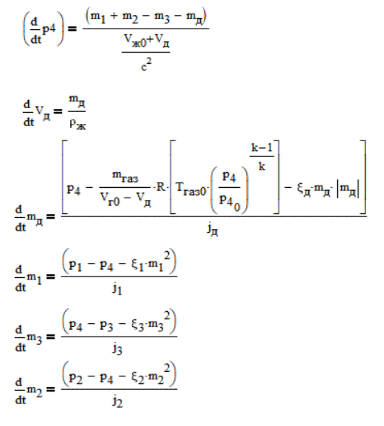

$$
\frac{d}{dt}m_{д} = \frac{ \left[ p_{4}-\frac{m_{газ}}{V_{г0}-V_{д}} \cdot R \cdot \left[T_{газ0} \cdot \left(\frac{p_{4}}{p_{4,0}} \right)^{\frac{k-1}{k}} \right] - \xi_{д} \cdot m_{д} \cdot \left| m_{д} \right| \right]}{j_{д}}
$$

## Решение системы дифференциальных уравнений методом Рунге-Кутта

### Пример решения в ручную

In [1]:
def equations(t , *args) :  
    """Функция, содержащая правые части дифф. уравнений"""
    return [
        (m1+m2-m3-md) / ((V_liq_0 + Vd) / pow(c, 2))
        ]


def rk(func, t0, tf, y0, h) :
    count = int( (tf - t0) / h ) + 1
    y = [ y0[:] ]
    x = t0
    for i in range (1 , count ) :
        k1 = func(x, y[i - 1])
        k2 = func(x + h/2, list(map(lambda arr1, arr2: arr1 + arr2 * h/2, y[i - 1], k1)))
        k3 = func(x + h/2, list(map(lambda arr1, arr2: arr1 + arr2 * h/2, y[i - 1], k2)))
        k4 = func(x + h  , list(map(lambda arr1, arr2: arr1 + arr2 * h  , y[i - 1], k3)))
        
        y.append([])
        
        for j in range ( len ( y0 ) ) :
            y[i].append(y[i - 1][j] + h/6 * (k1[j] + 2 * k2[j] + 2 * k3[j] + k4[j]))

        x += h
    return y

In [ ]:
ic()
for l in rk(equations, 0, 1, [0, 0, 0], 0.1):
    # print(l)
    ic(l)
    # ic()

ic| 2666118371.py:1 in <module> at 17:07:22.093
ic| l: [0, 0, 0]
ic| l: [0.004999791679686959, 0.10536054802945213, 0.09998750234339197]
ic| l: [0.019992089353337197, 0.22314364263845965, 0.19980027824237273]
ic| l: [0.04493954532954178, 0.35667514735386174, 0.2989921821997826]
ic| l: [0.07974589273138522, 0.5108260541264404, 0.39683477618392093]
ic| l: [0.1242292261307227, 0.6931481126736125, 0.49235154280802335]
ic| l: [0.1781000081292174, 0.9162929178666563, 0.5843789596377397]
ic| l: [0.24094662432104696, 1.2039787012997296, 0.67165612248553]
ic| l: [0.3122311354618596, 1.6094571435954672, 0.7529375201538153]
ic| l: [0.39129695254854, 2.302585909165211, 0.8271160064996047]
ic| l: [0.4773885589403407, 5.409112363921029, 0.8933374434985747]


### `This is a test`

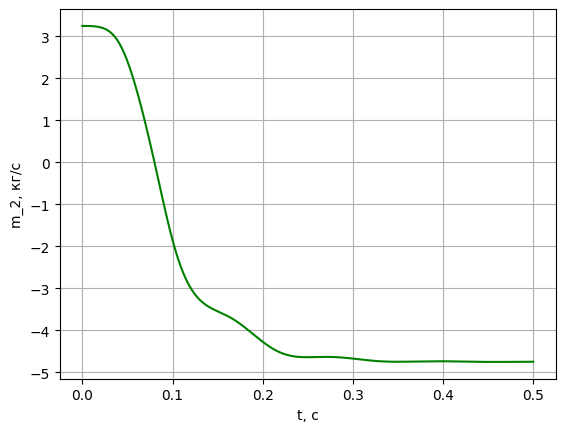

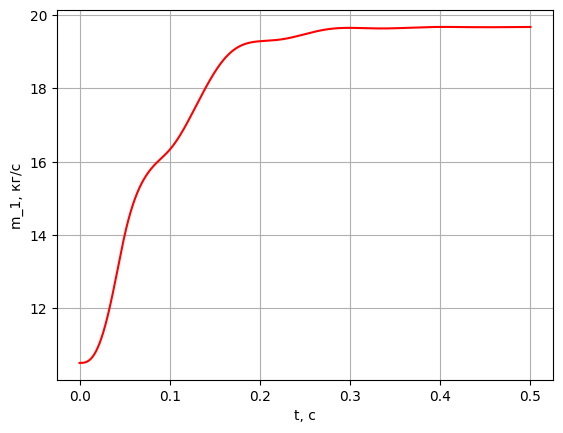

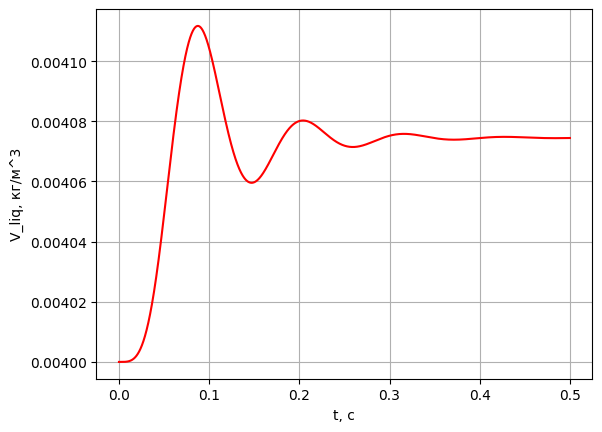

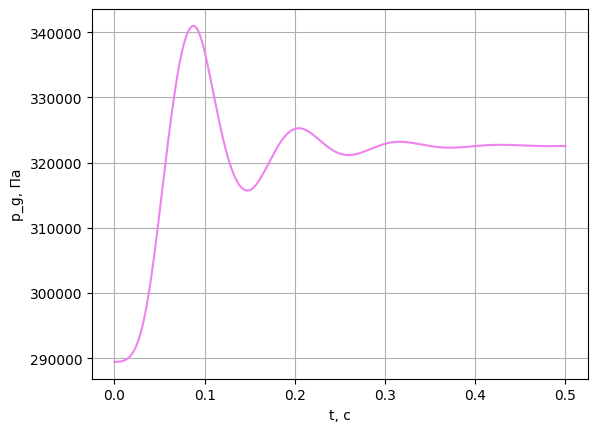

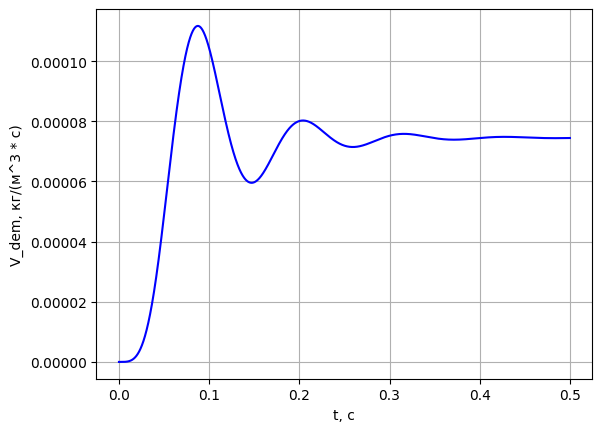

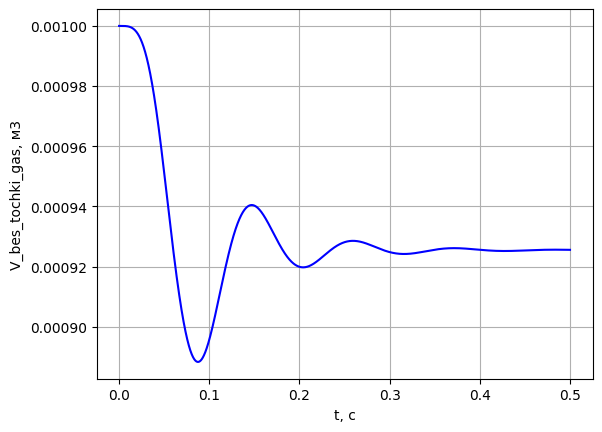

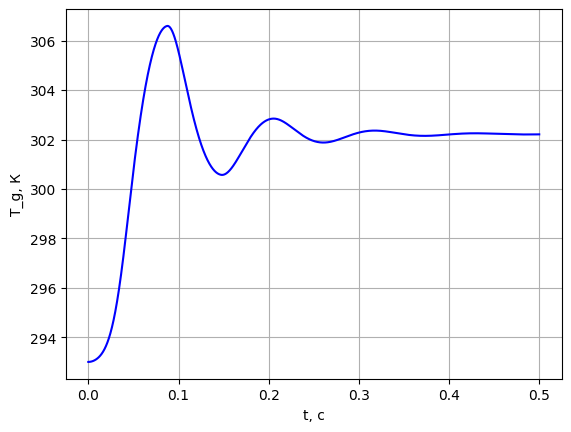

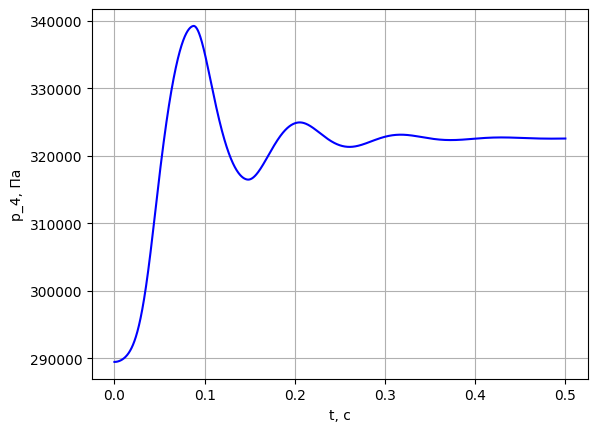

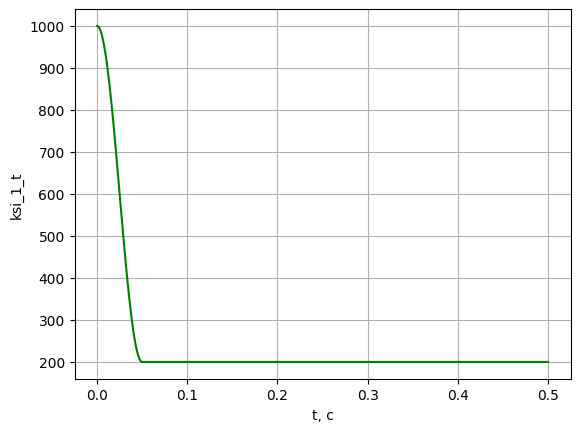

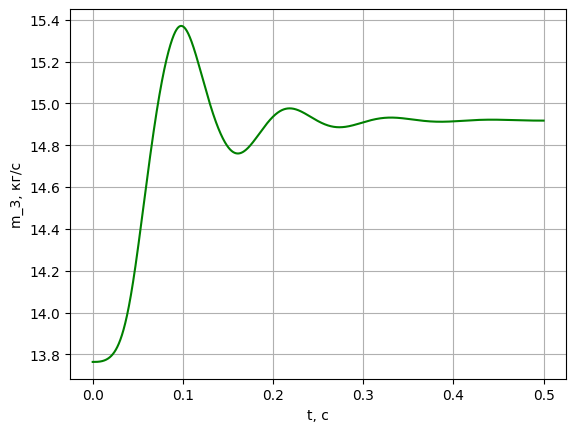

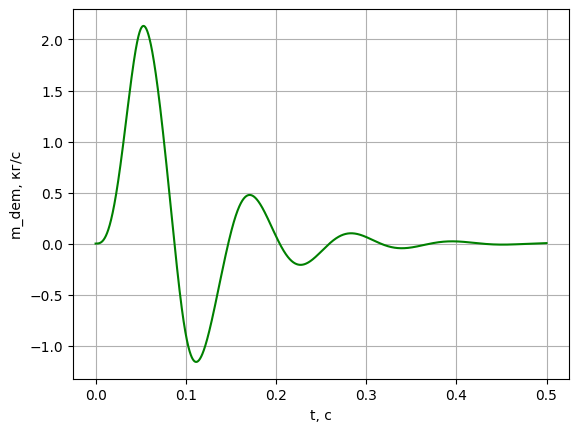

In [1]:
# from symtable import Symbol
# import matplotlib as mt
# import scipy as sc
# from sympy import *
# from scipy.optimize import root
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic


"""
Система уравнений описывающая стационарные процессы
"""

ksi_1 = 1000
ksi_2 = 1000
ksi_3 = 1000
ksi_dem = 1000
p_1 = 400000
p_2 = 300000
p_3 = 100000

p_4_0 = 289442.71909999158785636694674925104941762473438446102897
m_1_0 = 10.51462224238267212051338169695753214570995864486684
m_2_0 = 3.24919696232906326155871412215134464954903471521475
m_3_0 = 13.76381920471173538207209581910887679525899336008159
p_g_0 = 289_442_719_099_991_587_856_366_946_749_251_049_417_624_734_384_461_028_970e-51

l_1 = l_2 = l_3 = 1
l_dem = 0.02

S_1 = S_2 = S_3 = 0.0025
S_dem = 0.001

T_g_0 = 293
k = 1.4
R_gas = 287
R_liq = 287
ro_gas_0 = p_g_0 / R_gas / T_g_0 # Плотность газа
ro_liq_0 = 820 # Плотность жидкости
# print(ro_gas_0)
m_dem_0 = 0 # Это расход демпфера
V_dem_0 = 0 # Это расход демпфера
m_bes_tochki_dem_0 = 0 # Масса демпфера
V_bes_tochki_dem_0 = 0 # Объём демпфера

V_bes_tochki_gas_0 = 0.001 # Это объём газа !!!
m_bes_tochki_gas_0 = p_g_0 * V_bes_tochki_gas_0 / T_g_0 / R_gas  # Масса газа
# print(m_bes_tochki_gas_0)

V_liq_0 = 0.004 # Объём жидкости
m_liq_0 = V_liq_0 * ro_liq_0
# print(m_liq_0)
V = V_liq_0 + V_bes_tochki_gas_0 # Суммарный объём
C_liq = 1218 # Скорость звука в жидкости
alpha_0 = (V_liq_0 + V_bes_tochki_dem_0) / (C_liq ** 2)
p_4_1 = p_4_0

j_1 = l_1 / S_1
j_2 = l_2 / S_2
j_3 = l_3 / S_3
j_dem = l_dem / S_dem
# print(j_2, j_dem)

# j_1, j_2, j_3, j_dem = 0.01, 0.01, 0.01, 0.01

# t = Symbol('t')
# m_dem = symbols('m_dem', cls= Function)
# p_4 = symbols('p_4', cls= Function)
# m_3 = symbols('m_3', cls= Function)
# m_2 = symbols('m_2', cls= Function)
# m_1 = symbols('m_1', cls= Function)
# V_dem = symbols('V_dem', cls= Function)
#
# m_dem = Function('m_dem')
# p_4 = Function('p_4')
# m_3 = Function('m_3')
# m_2 = Function('m_2')
# m_1 = Function('m_1')
# V_dem = Function('V_dem')

# m_dem(0).diff(t) == 0
# ics = {m_dem(0): 0}
# Ny = m_dem(0) == 0, p_4(0) == p_4_0, m_3(0) == m_3_0, m_2(0) == m_2_0, m_1(0) == m_1_0, V_dem(0) == 0

# sistema = (Eq(m_dem(t).diff(t), (p_4(t) - p_2 - ksi_dem * m_dem(t) ** 2) / j_dem),
#            Eq(m_1(t).diff(t), (p_1 - p_4(t) - ksi_1 * m_1(t)) / j_1),
#            Eq(m_3(t).diff(t), (p_4(t) - p_3 - ksi_3 * m_3(t)) / j_3),
#            Eq(m_2(t).diff(t), (p_2 - p_4(t) - ksi_2 * m_2(t)) / j_2),
#            Eq(p_4(t).diff(t), (m_1(t) + m_2(t) - m_3(t) - m_dem(t)) / alpha),
#            Eq(V_dem(t).diff(t), m_dem(t) / ro)
#            )
# sss = dsolve([sistema], [m_dem(0) == 0, p_4(0) == p_4_0, m_3(0) == m_3_0, m_2(0) == m_2_0, m_1(0) == m_1_0, V_dem(0) == 0])
# print(sss)

# ics = {m_dem(0) : 0, p_4(0) : p_4_0, m_3(0) : m_3_0, m_2(0) : m_2_0, m_1(0) : m_1_0, V_dem(0) : 0}

# eqns = [diff(m_dem(t), t) - (p_4(t) - p_2 - ksi_dem * (m_dem(t)) ** 2) / j_dem,
#         diff(m_1(t), t) - (p_1 - p_4(t) - ksi_1 * m_1(t)) / j_1,
#         diff(m_3(t), t) - (p_4(t) - p_3 - ksi_3 * m_3(t)) / j_3,
#         diff(m_2(t), t) - (p_2 - p_4(t) - ksi_2 * m_2(t)) / j_2,
#         diff(p_4(t), t) - (m_1(t) + m_2(t) - m_3(t) - m_dem(t)) / alpha,
#         diff(V_dem(t), t) - m_dem(t) / ro]

#
# sss = dsolve((diff(m_dem(t), t) - (p_4_0 - p_2 - ksi_dem * (m_dem(t)) ** 2) / j_dem,
#               diff(m_1(t), t) - (p_1 - p_4_0 - ksi_1 * m_1(t)) / j_1), ics = {m_dem(0): 0, m_1(0): m_1_0})

# print(sss)

# x = Function('x')
# p = Function('p')
# print(dsolve((diff(m_dem(t), t) - (p_4(t) - p_2 - ksi_dem * (m_dem(t)) ** 2) / j_dem,
#               diff(m_1(t), t) - (p_1 - p_4(t) - ksi_1 * m_1(t)) / j_1,
#               )))
#
# dsolve(
#     (diff(m_dem(t), t) - (p_4_0 - p_2 - ksi_dem * (m_dem(t)) ** 2) / j_dem,
#      diff(m_1(t), t) - (p_1 - p_4_0 - ksi_1 * m_1(t)) / j_1), hint='all', ics={m_dem(0): 0, m_1(0): m_1_0})

t_start = 0
t_end = 0.5
dt = 0.00001
T = 0.1

V_dem   = np.array(())
V_liq   = np.array(())
V_bes_tochki_gas = np.array(())
m_dem   = np.array(())
m_1     = np.array(())
m_3     = np.array(())
m_2     = np.array(())
p_4     = np.array(())
T_g     = np.array(())
t       = np.array(())
p_g     = np.array(())
ksi_1_t = np.array(())
delta_V_dem_1 = np.array(())
delta_m_1_1 =  np.array(())

for i in np.arange(t_start, t_end, dt):

    def ksi_1_t_t(t):
        return ksi_1 - 0.4 * ksi_1 * (np.sin(2 * np.pi * (t - T / 4) / T) + 1)

    if i <= T / 2:
        ksi_1_f = ksi_1_t_t(i)
    else:
        ksi_1_f = ksi_1_t_t(T / 2)

    T_g_0    = T_g_0 * (p_4_0 / p_4_1) ** ((k - 1) / k)
    p_g_0    = m_bes_tochki_gas_0 / V_bes_tochki_gas_0 * R_gas * T_g_0

    dV_dem_1 = dt * (m_dem_0 / ro_liq_0)
    dm_dem_1 = dt * (p_4_0 - p_g_0 - ksi_dem * m_dem_0 * abs(m_dem_0)) / j_dem
    # dm_1_1   = dt * (p_1 - p_4_0 - ksi_1 * m_1_0 * abs(m_1_0)) / j_1
    dm_1_1   = dt * (p_1 - p_4_0 - ksi_1_f * m_1_0 * abs(m_1_0)) / j_1
    dm_3_1   = dt * (p_4_0 - p_3 - ksi_3 * m_3_0 * abs(m_3_0)) / j_3
    dm_2_1   = dt * (p_2 - p_4_0 - ksi_2 * m_2_0 * abs(m_2_0)) / j_2
    dp_4_1   = dt * (m_1_0 + m_2_0 - m_3_0 - m_dem_0) / alpha_0

    dV_dem_2 = dt * ((m_dem_0 + dm_dem_1 / 2) / ro_liq_0)
    dm_dem_2 = dt * (p_4_0 + dp_4_1 / 2 - p_g_0 - ksi_dem * (m_dem_0 + dm_dem_1 / 2) * abs(m_dem_0 + dm_dem_1 / 2)) / j_dem
    # dm_1_2   = dt * (p_1 - (p_4_0 + dp_4_1 / 2) - ksi_1 * (m_1_0 + dm_1_1 / 2) * abs(m_1_0 + dm_1_1 / 2)) / j_1
    dm_1_2   = dt * (p_1 - (p_4_0 + dp_4_1 / 2) - ksi_1_f * (m_1_0 + dm_1_1 / 2) * abs(m_1_0 + dm_1_1 / 2)) / j_1
    dm_3_2   = dt * (p_4_0 + dp_4_1 / 2 - p_3 - ksi_3 * (m_3_0 + dm_3_1 / 2) * abs(m_3_0 + dm_3_1 / 2)) / j_3
    dm_2_2   = dt * (p_2 - (p_4_0 + dp_4_1 / 2) - ksi_2 * (m_2_0 + dm_2_1 / 2) * abs(m_2_0 + dm_2_1 / 2)) / j_2
    dp_4_2   = dt * (m_1_0 + dm_1_1 / 2 + m_2_0 + dm_2_1 / 2 - (m_3_0 + dm_3_1 / 2) - (m_dem_0 + dm_dem_1 / 2)) / alpha_0

    dV_dem_3 = dt * ((m_dem_0 + dm_dem_2 / 2) / ro_liq_0)
    dm_dem_3 = dt * (p_4_0 + dp_4_2 / 2 - p_g_0 - ksi_dem * (m_dem_0 + dm_dem_2 / 2) * abs(m_dem_0 + dm_dem_2 / 2)) / j_dem
    # dm_1_3   = dt * (p_1 - (p_4_0 + dp_4_2 / 2) - ksi_1 * (m_1_0 + dm_1_2 / 2) * abs(m_1_0 + dm_1_2 / 2)) / j_1
    dm_1_3   = dt * (p_1 - (p_4_0 + dp_4_2 / 2) - ksi_1_f * (m_1_0 + dm_1_2 / 2) * abs(m_1_0 + dm_1_2 / 2)) / j_1
    dm_3_3   = dt * (p_4_0 + dp_4_2 / 2 - p_3 - ksi_3 * (m_3_0 + dm_3_2 / 2) * abs(m_3_0 + dm_3_2 / 2)) / j_3
    dm_2_3   = dt * (p_2 - (p_4_0 + dp_4_2 / 2) - ksi_2 * (m_2_0 + dm_2_2 / 2) * abs(m_2_0 + dm_2_2 / 2)) / j_2
    dp_4_3   = dt * (m_1_0 + dm_1_2 / 2 + m_2_0 + dm_2_2 / 2 - (m_3_0 + dm_3_2 / 2) - (m_dem_0 + dm_dem_2 / 2)) / alpha_0

    dV_dem_4 = dt * ((m_dem_0 + dm_dem_3) / ro_liq_0)
    dm_dem_4 = dt * (p_4_0 + dp_4_3 - p_g_0 - ksi_dem * (m_dem_0 + dm_dem_3) * abs(m_dem_0 + dm_dem_3)) / j_dem
    # dm_1_4   = dt * (p_1 - (p_4_0 + dp_4_3) - ksi_1 * (m_1_0 + dm_1_3) * abs(m_1_0 + dm_1_3)) / j_1
    dm_1_4   = dt * (p_1 - (p_4_0 + dp_4_3) - ksi_1_f * (m_1_0 + dm_1_3) * abs(m_1_0 + dm_1_3)) / j_1
    dm_3_4   = dt * (p_4_0 + dp_4_3 - p_3 - ksi_3 * (m_3_0 + dm_3_3) * abs(m_3_0 + dm_3_3)) / j_3
    dm_2_4   = dt * (p_2 - (p_4_0 + dp_4_3) - ksi_2 * (m_2_0 + dm_2_3) * abs(m_2_0 + dm_2_3)) / j_2
    dp_4_4   = dt * (m_1_0 + dm_1_3 + m_2_0 + dm_2_3 - (m_3_0 + dm_3_3) - (m_dem_0 + dm_dem_3)) / alpha_0

    delta_V_dem = (dV_dem_1 + 2 * dV_dem_2 + 2 * dV_dem_3 + dV_dem_4) / 6
    delta_m_dem = (dm_dem_1 + 2 * dm_dem_2 + 2 * dm_dem_3 + dm_dem_4) / 6
    delta_m_1   = (dm_1_1 + 2 * dm_1_2 + 2 * dm_1_3 + dm_1_4) / 6
    delta_m_3   = (dm_3_1 + 2 * dm_3_2 + 2 * dm_3_3 + dm_3_4) / 6
    delta_m_2   = (dm_2_1 + 2 * dm_2_2 + 2 * dm_2_3 + dm_2_4) / 6
    delta_p_4   = (dp_4_1 + 2 * dp_4_2 + 2 * dp_4_3 + dp_4_4) / 6

    p_4_1    = p_4_0
    V_dem_0  = V_dem_0 + delta_V_dem
    V_liq_i  = V_liq_0 + V_dem_0
    V_bes_tochki_gas_0 = V - V_liq_i
    alpha_0  = V_liq_i / (C_liq ** 2)
    m_dem_0  = m_dem_0 + delta_m_dem
    m_1_0    = m_1_0 + delta_m_1
    m_3_0    = m_3_0 + delta_m_3
    m_2_0    = m_2_0 + delta_m_2
    p_4_0    = p_4_0 + delta_p_4

    delta_V_dem_1 = np.append(delta_V_dem_1, delta_V_dem)
    p_g    = np.append(p_g, p_g_0)
    V_dem  = np.append(V_dem, V_dem_0)
    V_liq  = np.append(V_liq, V_liq_i)
    V_bes_tochki_gas = np.append(V_bes_tochki_gas, V_bes_tochki_gas_0)
    m_dem  = np.append(m_dem, m_dem_0)
    m_1    = np.append(m_1, m_1_0)
    m_3    = np.append(m_3, m_3_0)
    m_2    = np.append(m_2, m_2_0)
    p_4    = np.append(p_4, p_4_0)
    T_g    = np.append(T_g, T_g_0)
    t      = np.append(t, i)
    ksi_1_t= np.append(ksi_1_t, ksi_1_f)
    delta_m_1_1 = np.append(delta_m_1_1, delta_m_1)

    # print(m_dem_0)
# print(p_4)

# for i in np.arange(t_start, t_end, dt):
#
#     def ksi_1_t_t(t):
#         return ksi_1 + 0.4 * ksi_1 * (np.sin(2 * np.pi * (t - T / 4) / T) + 1)
#
#     def fun_alpha(x):
#         return (V_liq_0 + x) / C_liq ** 2
#
#     T_g_0 = T_g_0 * (p_4_0 / p_4_1) ** ((k - 1) / k)
#
#     def fun_T_g_0(x):
#         return T_g_0 * ((p_4_0 + x) / p_4_1) ** ((k - 1) / k)
#
#     if i <= T / 2:
#         ksi_1_f = ksi_1_t_t(i)
#     else:
#         ksi_1_f = ksi_1_t_t(T / 2)
#
#     # p_g_0    = m_bes_tochki_gas_0 / V_bes_tochki_gas_0 * R_gas * T_g_0
#
#     dV_dem_1 = dt * (m_dem_0 / ro_liq_0)
#     dm_dem_1 = dt * (p_4_0 - (m_bes_tochki_gas_0 / (V - (V_liq_0)) * R_gas * fun_T_g_0(0)) - ksi_dem * m_dem_0 * abs(m_dem_0)) / j_dem
#     # dm_1_1   = dt * (p_1 - p_4_0 - ksi_1 * m_1_0 * abs(m_1_0)) / j_1
#     dm_1_1   = dt * (p_1 - p_4_0 - ksi_1_f * m_1_0 * abs(m_1_0)) / j_1
#     dm_3_1   = dt * (p_4_0 - p_3 - ksi_3 * m_3_0 * abs(m_3_0)) / j_3
#     dm_2_1   = dt * (p_2 - p_4_0 - ksi_2 * m_2_0 * abs(m_2_0)) / j_2
#     dp_4_1   = dt * (m_1_0 + m_2_0 - m_3_0 - m_dem_0) / fun_alpha(0)
#
#     dV_dem_2 = dt * ((m_dem_0 + dm_dem_1 / 2) / ro_liq_0)
#     dm_dem_2 = dt * (p_4_0 + dp_4_1 / 2 - (m_bes_tochki_gas_0 / (V - (V_liq_0 + dV_dem_1 / 2)) * R_gas * fun_T_g_0(dp_4_1 / 2)) - ksi_dem *
#                      (m_dem_0 + dm_dem_1 / 2) * abs(m_dem_0 + dm_dem_1 / 2)) / j_dem
#     # dm_1_2   = dt * (p_1 - p_4_0 + dp_4_1 / 2 - ksi_1 * (m_1_0 + dm_1_1 / 2) * abs(m_1_0 + dm_1_1 / 2)) / j_1
#     dm_1_2   = dt * (p_1 - (p_4_0 + dp_4_1 / 2) - ksi_1_f * (m_1_0 + dm_1_1 / 2) * abs(m_1_0 + dm_1_1 / 2)) / j_1
#     dm_3_2   = dt * (p_4_0 + dp_4_1 / 2 - p_3 - ksi_3 * (m_3_0 + dm_3_1 / 2) * abs(m_3_0 + dm_3_1 / 2)) / j_3
#     dm_2_2   = dt * (p_2 - (p_4_0 + dp_4_1 / 2) - ksi_2 * (m_2_0 + dm_2_1 / 2) * abs(m_2_0 + dm_2_1 / 2)) / j_2
#     dp_4_2   = dt * (m_1_0 + dm_1_1 / 2 + m_2_0 + dm_2_1 / 2 - (m_3_0 + dm_3_1 / 2) - (m_dem_0 + dm_dem_1 / 2)) / fun_alpha(dV_dem_1 / 2)
#
#     dV_dem_3 = dt * ((m_dem_0 + dm_dem_2 / 2) / ro_liq_0)
#     dm_dem_3 = dt * (p_4_0 + dp_4_2 / 2 - (m_bes_tochki_gas_0 / (V - (V_liq_0 + dV_dem_2 / 2)) * R_gas * fun_T_g_0(dp_4_2 / 2)) - ksi_dem
#                      * (m_dem_0 + dm_dem_2 / 2) * abs(m_dem_0 + dm_dem_2 / 2)) / j_dem
#     # dm_1_3   = dt * (p_1 - p_4_0 + dp_4_2 / 2 - ksi_1 * (m_1_0 + dm_1_2 / 2) * abs(m_1_0 + dm_1_2 / 2)) / j_1
#     dm_1_3   = dt * (p_1 - (p_4_0 + dp_4_2 / 2) - ksi_1_f * (m_1_0 + dm_1_2 / 2) * abs(m_1_0 + dm_1_2 / 2)) / j_1
#     dm_3_3   = dt * (p_4_0 + dp_4_2 / 2 - p_3 - ksi_3 * (m_3_0 + dm_3_2 / 2) * abs(m_3_0 + dm_3_2 / 2)) / j_3
#     dm_2_3   = dt * (p_2 - (p_4_0 + dp_4_2 / 2) - ksi_2 * (m_2_0 + dm_2_2 / 2) * abs(m_2_0 + dm_2_2 / 2)) / j_2
#     dp_4_3   = dt * (m_1_0 + dm_1_2 / 2 + m_2_0 + dm_2_2 / 2 - (m_3_0 + dm_3_2 / 2) - (m_dem_0 + dm_dem_2 / 2)) / fun_alpha(dV_dem_2 / 2)
#
#     dV_dem_4 = dt * ((m_dem_0 + dm_dem_3) / ro_liq_0)
#     dm_dem_4 = dt * (p_4_0 + dp_4_3 - (m_bes_tochki_gas_0 / (V - (V_liq_0 + dV_dem_3)) * R_gas * fun_T_g_0(dp_4_3)) - ksi_dem
#                      * (m_dem_0 + dm_dem_3) * abs(m_dem_0 + dm_dem_3)) / j_dem
#     # dm_1_4   = dt * (p_1 - p_4_0 + dp_4_3 - ksi_1 * (m_1_0 + dm_1_3) * abs(m_1_0 + dm_1_3)) / j_1
#     dm_1_4   = dt * (p_1 - (p_4_0 + dp_4_3) - ksi_1_f * (m_1_0 + dm_1_3) * abs(m_1_0 + dm_1_3)) / j_1
#     dm_3_4   = dt * (p_4_0 + dp_4_3 - p_3 - ksi_3 * (m_3_0 + dm_3_3) * abs(m_3_0 + dm_3_3)) / j_3
#     dm_2_4   = dt * (p_2 - (p_4_0 + dp_4_3) - ksi_2 * (m_2_0 + dm_2_3) * abs(m_2_0 + dm_2_3)) / j_2
#     dp_4_4   = dt * (m_1_0 + dm_1_3 + m_2_0 + dm_2_3 - (m_3_0 + dm_3_3) - (m_dem_0 + dm_dem_3)) / fun_alpha(dV_dem_3)
#
#     delta_V_dem = (dV_dem_1 + 2 * dV_dem_2 + 2 * dV_dem_3 + dV_dem_4) / 6
#     delta_m_dem = (dm_dem_1 + 2 * dm_dem_2 + 2 * dm_dem_3 + dm_dem_4) / 6
#     delta_m_1   = (dm_1_1 + 2 * dm_1_2 + 2 * dm_1_3 + dm_1_4) / 6
#     delta_m_3   = (dm_3_1 + 2 * dm_3_2 + 2 * dm_3_3 + dm_3_4) / 6
#     delta_m_2   = (dm_2_1 + 2 * dm_2_2 + 2 * dm_2_3 + dm_2_4) / 6
#     delta_p_4   = (dp_4_1 + 2 * dp_4_2 + 2 * dp_4_3 + dp_4_4) / 6
#
#     p_4_1    = p_4_0
#     V_dem_0  = V_dem_0 + delta_V_dem
#     V_liq_0  = V_liq_0 + V_dem_0
#     V_bes_tochki_gas_0 = V - V_liq_0
#     # alpha_0  = V_liq_i / (C_liq ** 2)
#     m_dem_0  = m_dem_0 + delta_m_dem
#     m_1_0    = m_1_0 + delta_m_1
#     m_3_0    = m_3_0 + delta_m_3
#     m_2_0    = m_2_0 + delta_m_2
#     p_4_0    = p_4_0 + delta_p_4
#
#     delta_V_dem_1 = np.append(delta_V_dem_1, delta_p_4)
#     p_g    = np.append(p_g, p_g_0)
#     V_dem  = np.append(V_dem, V_dem_0)
#     V_liq  = np.append(V_liq, V_liq_0)
#     V_bes_tochki_gas = np.append(V_bes_tochki_gas, V_bes_tochki_gas_0)
#     m_dem  = np.append(m_dem, m_dem_0)
#     m_1    = np.append(m_1, m_1_0)
#     m_3    = np.append(m_3, m_3_0)
#     m_2    = np.append(m_2, m_2_0)
#     p_4    = np.append(p_4, p_4_0)
#     T_g    = np.append(T_g, T_g_0)
#     t      = np.append(t, i)
#     ksi_1_t= np.append(ksi_1_t, ksi_1_f)
#     delta_m_1_1 = np.append(delta_m_1_1, delta_m_1)
#
#     # print(m_dem_0)
# # print(p_4)


def plot_graphs(names, x_labels, y_labels, colors, x_data, y_data):
    for i in range(len(names)):
        plt.figure(names[i])
        plt.xlabel(x_labels[i])
        plt.ylabel(y_labels[i])
        plt.plot(x_data[i], y_data[i], color=colors[i])
        plt.grid()


names = ['m_2', 'm_1', 'V_liq', 'p_g', 'V_dem', 'V_bes_tochki_gas', 'T_g', 'p_4', 'ksi_1_t', 'm_3', 'm_dem']
x_labels = ['t, с', 't, с', 't, с', 't, с', 't, с', 't, с', 't, с', 't, с', 't, с', 't, с', 't, с']
y_labels = ['m_2, кг/с', 'm_1, кг/с', 'V_liq, кг/м^3', 'p_g, Па', 'V_dem, кг/(м^3 * c)', 'V_bes_tochki_gas, м3', 'T_g, К', 'p_4, Па', 'ksi_1_t', 'm_3, кг/с', 'm_dem, кг/с']
colors = ['green', 'red', 'red', 'violet', 'blue', 'blue', 'blue', 'blue', 'green', 'green', 'green']
x_data = [t, t, t, t, t, t, t, t, t, t, t]
y_data = [m_2, m_1, V_liq, p_g, V_dem, V_bes_tochki_gas, T_g, p_4, ksi_1_t, m_3, m_dem]

plot_graphs(names, x_labels, y_labels, colors, x_data, y_data)

### Пробное решение

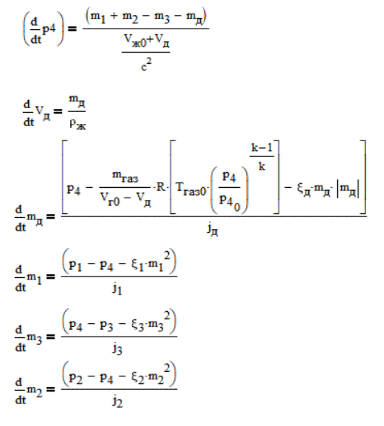

                   0             1         2          3         4          5
0      289442.719000  0.000000e+00  0.000000  10.515000  3.249000  13.764000
1      289429.713183  1.101603e-11  0.001807  10.515000  3.249000  13.764000
2      289390.711107  4.406272e-11  0.003613  10.515001  3.249001  13.763999
3      289325.756772  9.913611e-11  0.005419  10.515002  3.249003  13.763997
4      289234.930191  1.762290e-10  0.007224  10.515006  3.249007  13.763993
...              ...           ...       ...        ...       ...        ...
40973  301458.943546  2.724549e-03 -1.986070  10.122868  1.994796  14.103543
40974  301459.679784  2.724525e-03 -1.986467  10.122769  1.994561  14.103607
40975  301460.415168  2.724501e-03 -1.986864  10.122671  1.994325  14.103671
40976  301461.149718  2.724477e-03 -1.987261  10.122573  1.994090  14.103734
40977  301461.883490  2.724452e-03 -1.987658  10.122475  1.993855  14.103798

[40978 rows x 6 columns]


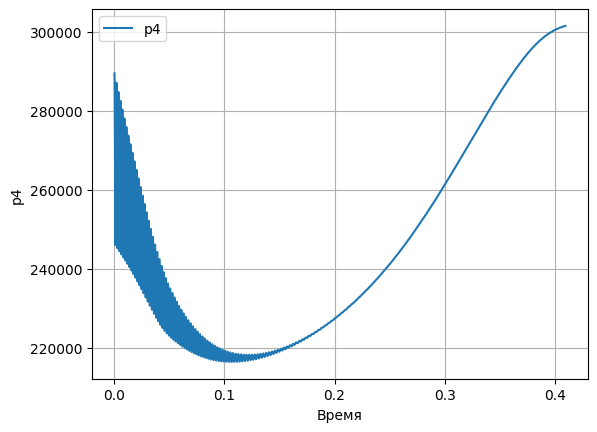

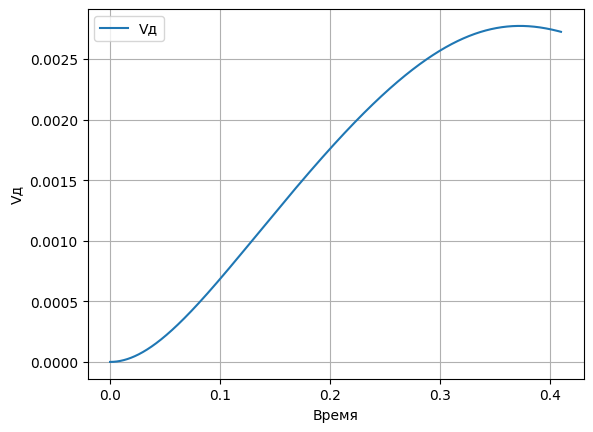

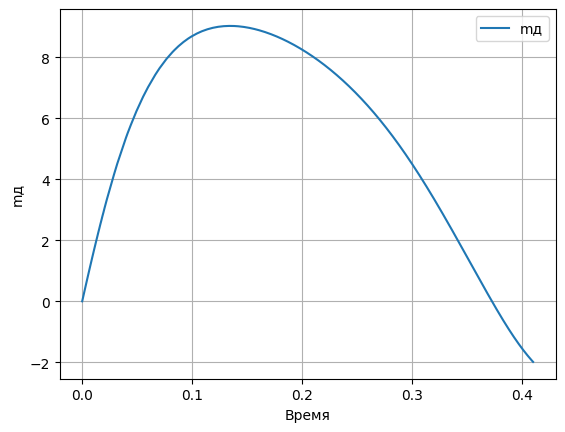

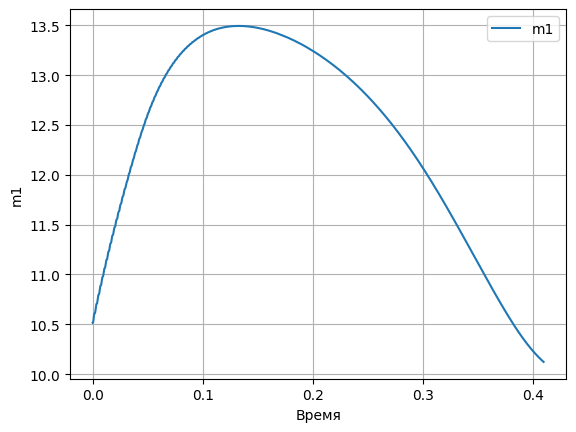

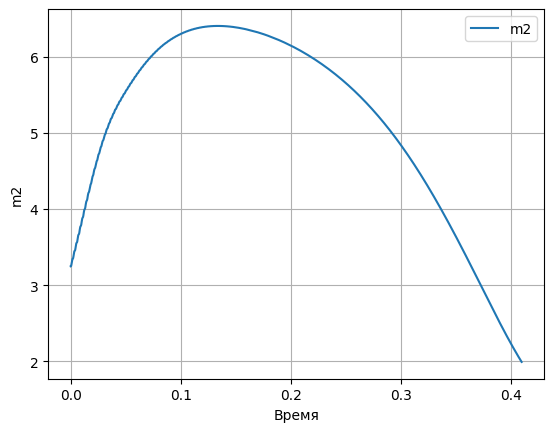

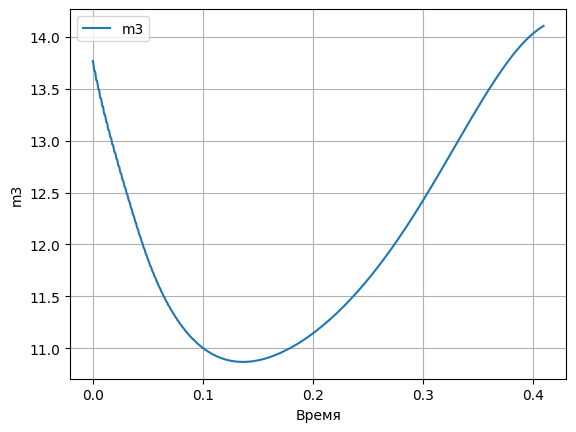

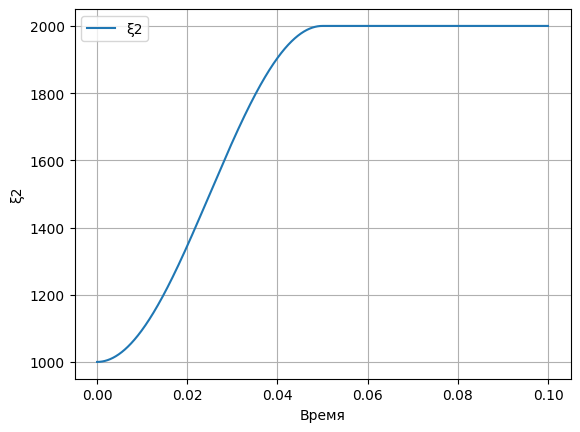

In [55]:
from scipy.integrate import odeint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def system(y, t):
    p4, Vд, mд, m1, m2, m3 = y
    
    d_p4 = (m1 + m2 - m3 - mд) / ((Vж0 + Vд) / c**2)
    d_Vд = mд / ρж
    d_mд = (p4 - (mгаз / (Vг0 - Vд)) * R * (Tгаз0 * ((p4 / p4_0)**((k-1)/k))) - ξд * mд * abs(mд)) / jд
    d_m1 = (p1 - p4 - ξ1 * m1**2) / j1
    d_m2 = (p2 - p4 - ξ2(t) * m2**2) / j2
    d_m3 = (p4 - p3 - ξ3 * m3**2) / j3
    
    return [d_p4, d_Vд, d_mд, d_m1, d_m2, d_m3]


def ξ2(t):
    if t <= 0.1/2:
        ξ2 = (1000 + 500*(np.sin(2*np.pi / 0.1*(t-0.1/4)) + 1))
    else:
        ξ2 = (1000 + 2*500)
    return ξ2

p4_0 = 289442.719
Vд_0 = 0

mд_0 = 0
m1_0 = 10.515
m2_0 = 3.249
m3_0 = 13.764

Vж0 = 0.001
ρж = 820

mгаз = 0.005
Vг0 = 0.004
Tгаз0 = 293

j1 = 400
j2 = 400
j3 = 400
jд = 1000

ξ1 = 1000
# ξ2 = [1000]
ξ3 = 1000
ξд = 1000

# for t in t:
#     if t <= 0.1/2:
#         ξ2.append(1000 + 500*(np.sin(2*np.pi / 0.1*(t-0.1/4)) + 1))
#     else:
#         ξ2.append(1000 + 2*500)

t_end = 0.40977
num_points = 40978

y0 = [p4_0, Vд_0, mд_0, m1_0, m2_0, m3_0]
t = np.linspace(0, t_end, num_points)

sol = odeint(system, y0, t)

print(pd.DataFrame(data=sol))


def plot(t, y, label):
    plt.plot(t, y, label=label)
    plt.grid(True)
    plt.xlabel("Время")
    plt.ylabel(label)
    plt.legend()
    plt.show()


plot(t, sol[:, 0], "p4")
plot(t, sol[:, 1], "Vд")
plot(t, sol[:, 2], "mд")
plot(t, sol[:, 3], "m1")
plot(t, sol[:, 4], "m2")
plot(t, sol[:, 5], "m3")
plot(t[:10000], [ξ2(t) for t in t][:10000], "ξ2")